In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
# using the Apple metal framework to move tensors to GPU
torch.backends.mps.is_available()

True

In [4]:
with open('names.txt','r') as w:
    names = w.read()
    names = names.splitlines()

In [5]:
len(names)

32033

In [6]:
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos= {s:i for i,s in stoi.items()}
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
block_size = 3

x, y = [], []

for w in names:
    
    # print(w)

    context = [0] * block_size

    for ch in w + '.':
        ix = stoi[ch]
        x.append(context)
        y.append(ix)

        # print(''.join(itos[i] for i in context),'--->',itos[ix])

        context = context[1:] + [ix]

x = torch.tensor(x)
y = torch.tensor(y)

In [8]:
def build_dataset(words):
    block_size = 3 #context length / how many chars do we need to predict the next word
    x, y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape,y.shape)
    return x, y

# split our dataset into train, dev and test
import random
random.seed(42)
random.shuffle(names)

n1 = int(0.7*len(names))
n2 = int(0.9*len(names))

xtr, ytr = build_dataset(names[:n1])
xdev, ydev = build_dataset(names[n1:n2])
xtest, ytest = build_dataset(names[n2:])

torch.Size([159846, 3]) torch.Size([159846])
torch.Size([45434, 3]) torch.Size([45434])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
len(names),n1,n2

(32033, 22423, 28829)

Now we embedd our 27 characters into a 2-D space.

In [10]:
# for every 27 chars we have a 2-D space on which it is mapped on
C = torch.randn((27,2))

### Below we do some tensor gymnastics to see how effective pytorch indexing is and how we can simply index into C from x using C[x].

In [11]:
x[:2], x[:2].shape

(tensor([[0, 0, 0],
         [0, 0, 5]]),
 torch.Size([2, 3]))

In [12]:
x[13,2]

tensor(1)

In [13]:
C[x[13]][2]

tensor([0.0204, 0.4324])

In [14]:
C[1]

tensor([0.0204, 0.4324])

In [15]:
C[[1,2,3]]

tensor([[ 0.0204,  0.4324],
        [ 0.7091,  0.5945],
        [-1.6140,  1.2059]])

In [16]:
C[x[:2]], C[x[:2]].shape

(tensor([[[-0.0537,  1.1783],
          [-0.0537,  1.1783],
          [-0.0537,  1.1783]],
 
         [[-0.0537,  1.1783],
          [-0.0537,  1.1783],
          [ 2.1887,  0.0866]]]),
 torch.Size([2, 3, 2]))

## Now we implement the embedding lookup table

In [17]:
emb = C[x]
emb.shape

torch.Size([228146, 3, 2])

## To move our inputs to the next layer we would want to do 
1. emb @ W1 + b
2. But, we can't do that as emb and W1 are not shape compatible
3. So we do something familiar, i.e reshape/view of emb

In [18]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [19]:
# h = emb.view(32,6) @ W1 + b1 we change this in favour of below, as the magic -1 pops up.
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #also add a tanh to ensure ouputs btw -1 and 1, our non-linearity
h.shape

torch.Size([228146, 100])

In [20]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [21]:
logits = h @ W2 + b2

In [22]:
logits.shape

torch.Size([228146, 27])

In [23]:
counts = logits.exp()

In [24]:
probs = counts / counts.sum (1, keepdim = True)

In [25]:
probs.shape

torch.Size([228146, 27])

In [26]:
#  again why log, if the probability is very high, we get the output close to zero, else if close to zero, we get hugely -ve.
loss = -probs[torch.arange(32),y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

## Lets make it respectable :)

In [ ]:
x.shape, y.shape #dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
# intialising all our embeddings, layers and biases
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27,10),generator=g)
W1 = torch.randn((30,200),generator=g) / 30**0.5
b1 = torch.randn(200,generator=g) * 0.01
W2 = torch.randn((200,27),generator=g) / 200**0.5
b2 = torch.randn(27,generator=g) * 0
parameters = [C,W1,b1,W2,b2]

In [ ]:
z = []
for p in parameters:
    z.append(p.numel()) #numel returns the number of elements in the tensor
x,sum(z)

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 3481)

This is great way to get the total number of parameters.

In [ ]:
sum(p.numel() for p in parameters)

11897

In [ ]:
# forward pass
emb = C[x]
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)

## The below is a manual implemenation of negative log-likelihood loss or cross entropy loss, highly inefficient
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True)
# loss = -probs[torch.arange(32),y].log().mean()

loss = F.cross_entropy(logits,y) # we can always replace the manual implementation of cross entropy with the direct funtion call, as its much faster
loss

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1140730x6 and 30x200)

In [115]:
# enable gradient tracking
for p in parameters:
    p.requires_grad = True

Here we're trying to find a good learning rate.

In [ ]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [116]:
batch_size = 32
lri = []
lossi = []

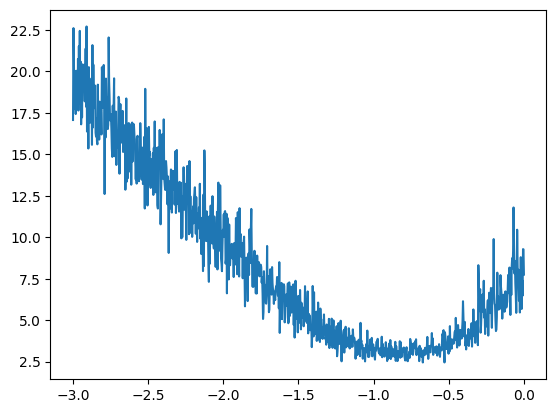

In [ ]:
plt.plot(lri,lossi)
# As we can see that we can find a good learning rate which comes to around -1.0, or 10^-1 = 0.1
# So 0.1 is a good learning rate.

In [117]:
for i in range(100000):

    # minibatch initialisation
    ix = torch.randint(0,xtr.shape[0],(batch_size,))

    # forward pass
    emb = C[xtr[ix]]
    hpreact = emb.view(-1,30) @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits,ytr[ix]) 
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()


    # Update
    # lr = lrs[i]
    lr = 10**-2/(1+i*(10**-3))
    for p in parameters:
        p.data += -lr * p.grad
    
    # # trac stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

    # print(f"{loss.item():.4f}")
    # break
    if i % 1000 == 0:
        print(loss.item())


3.3062853813171387
2.974088191986084
2.3398549556732178
2.475644826889038
2.2734122276306152
2.5097498893737793
2.960704803466797
2.7013230323791504
2.471424102783203
2.824748992919922
2.1447184085845947
2.551069974899292
2.097261428833008
2.212000846862793
2.571485757827759
2.5875160694122314
2.3799808025360107
2.3414056301116943
2.2316293716430664
2.4796955585479736
2.472080945968628
2.677234649658203
2.6247081756591797
2.2016396522521973
2.650261163711548
2.321901559829712
2.504429340362549
2.3331940174102783
2.5362706184387207
2.492830753326416
2.5114941596984863
2.5755703449249268
2.407522439956665
2.4036645889282227
2.240020513534546
2.2327959537506104
2.4664688110351562
2.2632079124450684
2.4708261489868164
2.369534492492676
2.6808221340179443
2.663846254348755
2.5149431228637695
2.321355104446411
2.4350855350494385
2.7723937034606934
2.225005865097046
2.225637674331665
2.091226816177368
2.5025827884674072
2.2791686058044434
2.739781379699707
2.601999044418335
2.652740716934204


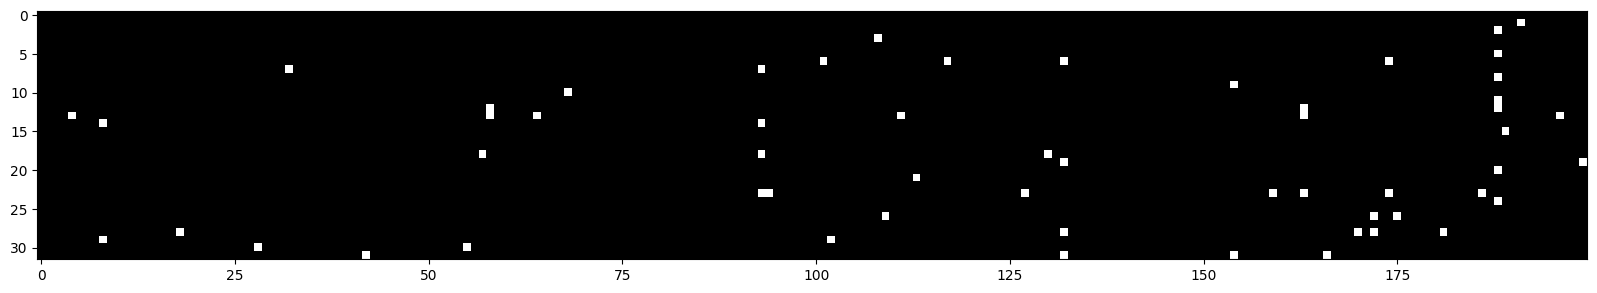

In [113]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()> 0.9,cmap='gray',interpolation='nearest')

In [82]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'berlin',
 'managua',
 'vanimo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',

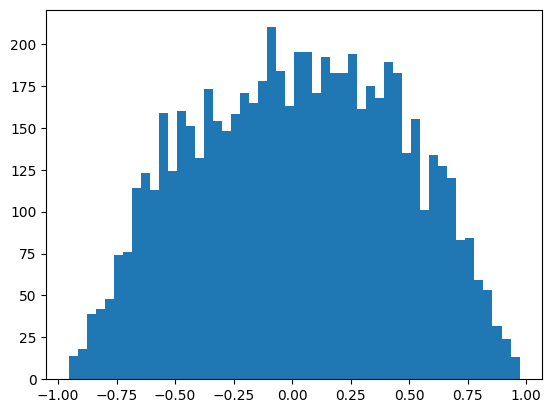

In [109]:
plt.hist(h.view(-1).tolist(),bins=50);

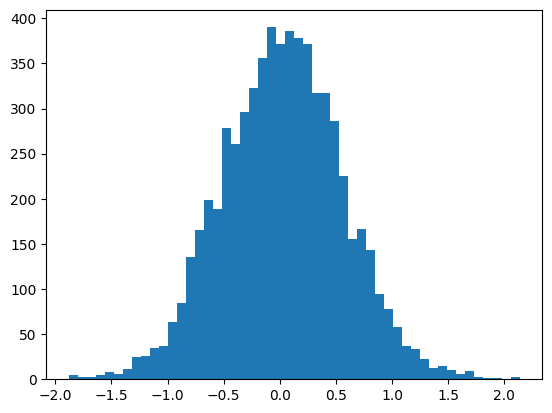

In [110]:
plt.hist(hpreact.view(-1).tolist(),bins=50);

In [ ]:
param_names = ['Embedding_lookup','W1','b1','W2','b2']
hyperparams: dict[str, float]
hyperparams = {name:p.shape for name,p in zip(param_names,parameters)}
hyperparams['Total_params'] = sum(p.numel() for p in parameters)
hyperparams['lr'] = lr
hyperparams['context_lenght'] = len(context)
hyperparams['batch_size'] = batch_size
hyperparams

{'Embedding_lookup': torch.Size([27, 10]),
 'W1': torch.Size([30, 200]),
 'b1': torch.Size([200]),
 'W2': torch.Size([200, 27]),
 'b2': torch.Size([27]),
 'Total_params': 11897,
 'lr': 0.01,
 'context_lenght': 3,
 'batch_size': 32}

In [ ]:
# training loss
emb = C[xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits,ytr)
loss

tensor(2.1859, grad_fn=<NllLossBackward0>)

In [ ]:
# dev loss
emb = C[xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits,ydev)
loss

tensor(2.2804, grad_fn=<NllLossBackward0>)

In [ ]:
lossi

[17.070384979248047,
 22.610342025756836,
 20.64112663269043,
 17.729372024536133,
 19.34000587463379,
 19.333986282348633,
 17.4310302734375,
 20.040176391601562,
 19.171550750732422,
 19.091968536376953,
 18.063207626342773,
 20.743581771850586,
 17.64053726196289,
 21.521209716796875,
 18.28887939453125,
 22.444664001464844,
 18.03293228149414,
 20.586177825927734,
 16.8083438873291,
 20.45482635498047,
 17.229612350463867,
 20.186595916748047,
 20.32685661315918,
 19.778226852416992,
 20.404518127441406,
 18.96505355834961,
 18.19423484802246,
 19.303178787231445,
 21.37774658203125,
 17.87245750427246,
 22.7100887298584,
 16.373493194580078,
 18.33818817138672,
 18.584835052490234,
 15.352697372436523,
 20.25798797607422,
 17.343629837036133,
 16.889328002929688,
 17.439983367919922,
 17.97250747680664,
 18.906658172607422,
 19.585166931152344,
 15.574941635131836,
 21.585689544677734,
 16.618284225463867,
 20.409168243408203,
 18.217153549194336,
 17.785924911499023,
 19.01387023

In [ ]:
logits.max(1)[1]

tensor([ 1, 18, 14,  ..., 20,  0,  1])

In [ ]:
ydev

tensor([ 2,  5, 12,  ...,  5, 10,  0])

In [ ]:
10**-3/(1+100*(10**-8))

0.0009999990000010002